<a href="https://colab.research.google.com/github/imdeepmind/CrowdCount/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir data
!mkdir data/processed
!unzip -qq /content/drive/My\ Drive/Projects/Crowd\ Count/Dataset/dataset.zip -d ./data

In [0]:
LABELS_FILE="data/labels.csv"
READ_FOLDER="data/frames/"
SAVE_FOLDER="data/processed/"
IMAGE_SIZE=555
IMAGE_CHANNEL=1
BATCH_SIZE=32
EPOCHS=100

In [0]:
from os.path import join
import cv2

def process_images(read_folder, save_folder, file):
    read_path = join(read_folder, file)
    save_path = join(save_folder, file)

    img = cv2.imread(read_path, 0)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

    cv2.imwrite(save_path, img)

    return save_path

In [5]:
import pandas as pd

data = pd.read_csv(LABELS_FILE)
labels = data["count"].values
print(labels[0:10])

[35 41 41 44 41 41 35 36 27 24]


In [6]:
from os import listdir
from tqdm import tqdm

images = listdir(READ_FOLDER)

dataset = []

for index, image in tqdm(enumerate(images)):
    save_path = process_images(READ_FOLDER, SAVE_FOLDER, image)
    dataset.append([save_path, labels[index]])

2000it [00:11, 180.60it/s]


In [7]:
print(dataset[0:10])

[['data/processed/seq_000019.jpg', 35], ['data/processed/seq_001959.jpg', 41], ['data/processed/seq_001231.jpg', 41], ['data/processed/seq_000884.jpg', 44], ['data/processed/seq_000874.jpg', 41], ['data/processed/seq_000845.jpg', 41], ['data/processed/seq_000014.jpg', 35], ['data/processed/seq_001701.jpg', 36], ['data/processed/seq_000499.jpg', 27], ['data/processed/seq_000677.jpg', 24]]


In [8]:
import pandas as pd

df = pd.DataFrame(dataset, columns=["path", "count"])

print(df.head())

                            path  count
0  data/processed/seq_000019.jpg     35
1  data/processed/seq_001959.jpg     41
2  data/processed/seq_001231.jpg     41
3  data/processed/seq_000884.jpg     44
4  data/processed/seq_000874.jpg     41


In [0]:
df.to_csv("data/processed.csv", index=False)

In [10]:
import numpy as np

train_data, validation_data, test_data = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

print(train_data.shape, validation_data.shape, test_data.shape)

(1600, 2) (200, 2) (200, 2)


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rotation_range=360,
    rescale=1./255,
    horizontal_flip=True,
	vertical_flip=True
)

test_generator = ImageDataGenerator(rescale=1./255)

In [12]:
train_data_gen = train_generator.flow_from_dataframe(
    train_data, 
    x_col="path", 
    y_col="count",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    color_mode="grayscale",
    class_mode="other",
    batch_size=BATCH_SIZE
)

validation_data_gen = test_generator.flow_from_dataframe(
    validation_data, 
    x_col="path", 
    y_col="count",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    color_mode="grayscale",
    class_mode="other",
    batch_size=BATCH_SIZE
)

test_data_gen = test_generator.flow_from_dataframe(
    test_data, 
    x_col="path", 
    y_col="count",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    color_mode="grayscale",
    class_mode="other",
    batch_size=BATCH_SIZE
)

Found 1600 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.


In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape=(IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNEL)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 

model.add(Dense(128, activation='relu'))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer="adam")

In [45]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 555, 555, 32)      320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 277, 277, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 277, 277, 64)      18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 138, 138, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 138, 138, 128)     73856     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 69, 69, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 69, 69, 256)      

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(
	monitor="val_loss",
	restore_best_weights=True,
	mode="min",
	patience=5)

In [47]:
history = model.fit(
    train_data_gen, 
    epochs=EPOCHS, 
    steps_per_epoch=1600 // BATCH_SIZE, 
    validation_data=validation_data_gen, 
    validation_steps= 200 // BATCH_SIZE,
    callbacks=[earlyStopping]
)

Epoch 1/100
50/50 [==============================] - 39s 783ms/step - loss: 5650.8057 - val_loss: 63.6612
Epoch 2/100
50/50 [==============================] - 38s 758ms/step - loss: 54.5003 - val_loss: 44.4359
Epoch 3/100
50/50 [==============================] - 38s 769ms/step - loss: 51.4031 - val_loss: 41.7362
Epoch 4/100
50/50 [==============================] - 38s 766ms/step - loss: 49.2075 - val_loss: 42.6035
Epoch 5/100
50/50 [==============================] - 38s 756ms/step - loss: 51.1086 - val_loss: 43.5021
Epoch 6/100
50/50 [==============================] - 38s 763ms/step - loss: 51.8460 - val_loss: 42.6228
Epoch 7/100
50/50 [==============================] - 38s 762ms/step - loss: 52.7324 - val_loss: 42.7827
Epoch 8/100
50/50 [==============================] - 38s 767ms/step - loss: 52.3863 - val_loss: 41.5125
Epoch 9/100
50/50 [==============================] - 38s 765ms/step - loss: 53.3725 - val_loss: 43.6576
Epoch 10/100
50/50 [==============================] - 39s 771m

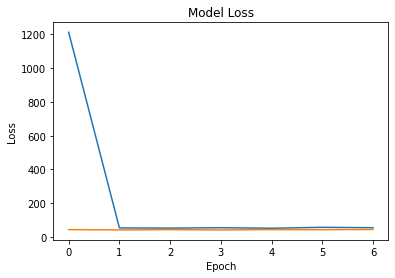

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

In [0]:
model.save("/content/drive/My Drive/Projects/Crowd Count/Weights/model.h5")  